In this notebook, we'll be using a GRU model for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

You can run the code implementation in this article on FloydHub using their GPUs on the cloud by clicking the following link and using the main.ipynb notebook.

[![Run on FloydHub](https://static.floydhub.com/button/button-small.svg)](https://floydhub.com/run?template=https://github.com/gabrielloye/https://github.com/gabrielloye/GRU_Prediction)

This will speed up the training process significantly. Alternatively, the link to the GitHub repository can be found [here]().

The goal of this implementation is to create a model that can accurately predict the energy usage in the next hour given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we’ll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will be using the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

In [1]:
#https://www.python-engineer.com/posts/pytorch-rnn-lstm-gru/

#https://blog.floydhub.com/gru-with-pytorch/

import os
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.model_selection import train_test_split






### Local ###
#from data_processing import *



# Define data root directory

#data_dir = "./data/"
#print(os.listdir(data_dir))

In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers.
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **lookback period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

In [37]:
choppeddata=pd.read_csv('choppeddata_9_21_2021.csv')#.head()

choppedheaders=[]
lookback=11 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    choppedheaders.append("header"+label)

#put chopped data in np.arrays
State=np.zeros((96,5,11)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long
Labels=np.zeros((96,11)) #96 runs, each run is 11 timesteps long
runcounter=0

for i in range(0,575,6):
            State[runcounter][0][:]=(choppeddata[choppedheaders[:]].iloc[i]).tolist()
            State[runcounter][1][:]=(choppeddata[choppedheaders[:]].iloc[i+1]).tolist()
            State[runcounter][2][:]=(choppeddata[choppedheaders[:]].iloc[i+2]).tolist()
            State[runcounter][3][:]=(choppeddata[choppedheaders[:]].iloc[i+3]).tolist()
            State[runcounter][4][:]=(choppeddata[choppedheaders[:]].iloc[i+4]).tolist()
            Labels[runcounter][:]=(choppeddata[choppedheaders[:]].iloc[i+5]).tolist()  #labels   
            runcounter+=1
#print(State[0])
#print(Labels)
print(Labels[:,10]) #just getting finals labels

[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [36]:
j = np.array([[ 0,  1,  2],
              [ 3,  4,  5],
              [ 6,  7,  8],
              [ 9, 10, 11]])
print(j)
print(j.shape)
print(j[:,2])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]
(4, 3)
[ 2  5  8 11]


In [203]:
#X= range(0,575,6)
#y= range(0,575,6)

X=State
y=Labels[:,10]
print(X.shape)

y=y.reshape(96,1)

random_seed=int(time.time())
#print(int(time.time()))
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size=.25, #0.33, 
                                                   random_state=random_seed)
print("Train")
print(train_x[0])
print(train_y.size)
print("Test")
print(test_x[0])
print(test_y[0])


(96, 5, 11)
Train
[[0.51155285 0.5808886  0.53975206 0.6510921  0.61266715 0.62850956
  0.62075803 0.62566591 0.63273678 0.64579588 0.62994267]
 [0.61063853 0.66180409 0.65323768 0.65395034 0.64457243 0.66113386
  0.66080114 0.66804335 0.6667479  0.65780242 0.67655053]
 [0.94489071 0.9149937  0.91107314 0.90861676 0.94506517 0.93692486
  0.94420469 0.94535766 0.94200471 0.94268051 0.90594796]
 [0.42114079 0.37571004 0.38395376 0.38177648 0.38929743 0.37666404
  0.37685371 0.3730353  0.37126032 0.37400449 0.36199284]
 [0.52374522 0.58244812 0.58014444 0.64578766 0.63892853 0.64713988
  0.64841248 0.65267164 0.65632271 0.66246562 0.657603  ]]
72
Test
[[0.49063884 0.49925682 0.50481392 0.46365528 0.47323396 0.47240898
  0.48315773 0.47511179 0.4938987  0.49539466 0.49241019]
 [0.60706388 0.60612928 0.71592971 0.70227609 0.70639497 0.71570873
  0.7335008  0.73810657 0.72110663 0.7366237  0.71649431]
 [0.94742484 0.94701368 0.94082099 0.9519257  0.95058435 0.94399667
  0.97016303 0.95044042

In [4]:
print(train_x.shape)  #example was (980185, 90, 5)

(64, 5, 11)


We have a total of 980,185 sequences of training data

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The Torch *Dataset* and *DataLoader* classes are useful for splitting our data into batches and shuffling them.

In [205]:
batch_size = 8
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data   = TensorDataset( torch.from_numpy( test_x ), torch.from_numpy( test_y ) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )


In [181]:
print(train_loader)

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using FloydHub with GPU to run this code, the training time will be significantly reduced.

In [206]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)


def get_torch_device( v=0 ):
    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()
    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
        if v:  print( "CUDA Available!" )
    else:
        device = torch.device("cpu")
        if v:  print( "NO CUDA" )
    return device

cuda


In [244]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
def train(train_loader, learn_rate, hidden_dim=128, EPOCHS=1000, model_type="GRU"):
    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%20 == 0:
            print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        
            print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss")
    plt.show()
    return model

def evaluate(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    for i in range( len( test_x ) ):    
        inp = torch.from_numpy(np.array(test_x[i])) # should be 5x1
        labs = torch.from_numpy(np.array(test_y[i])) #should be 1x1
        h = model.init_hidden(inp.shape[0])
        #print("inp",inp)
        #print("labs",labs)
        #print("h",h)
        out, h = model(inp.to(device).float(), h)
        #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
        outputs.append( out.cpu().detach().numpy().reshape(-1) )
        targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE
                               
def evaluate2(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    #for i in range( len( test_x ) ):    
    inp = torch.from_numpy(np.array(test_x)) # should be 5x1
    labs = torch.from_numpy(np.array(test_y)) #should be 1x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    outputs.append( out.cpu().detach().numpy().reshape(-1) )
    targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE                               

Starting Training of GRU model
Epoch 1/1000 Done, Total Loss: 0.34187072184350753
Total Time Elapsed: 0.020726999999993723 seconds
Epoch 2/1000 Done, Total Loss: 0.32282911075486076
Total Time Elapsed: 0.020792000000000144 seconds
Epoch 3/1000 Done, Total Loss: 0.2708994580639733
Total Time Elapsed: 0.019270999999989158 seconds
Epoch 4/1000 Done, Total Loss: 0.2518342700269487
Total Time Elapsed: 0.022728999999998223 seconds
Epoch 5/1000 Done, Total Loss: 0.2368029538128111
Total Time Elapsed: 0.017364999999998076 seconds
Epoch 6/1000 Done, Total Loss: 0.22958289086818695
Total Time Elapsed: 0.015550000000004616 seconds
Epoch 7/1000 Done, Total Loss: 0.23641462127367655
Total Time Elapsed: 0.017774000000002843 seconds
Epoch 8/1000 Done, Total Loss: 0.2351843085553911
Total Time Elapsed: 0.015242000000000644 seconds
Epoch 9/1000 Done, Total Loss: 0.24232423967785305
Total Time Elapsed: 0.01846299999999701 seconds
Epoch 10/1000 Done, Total Loss: 0.23554378913508522
Total Time Elapsed: 0.

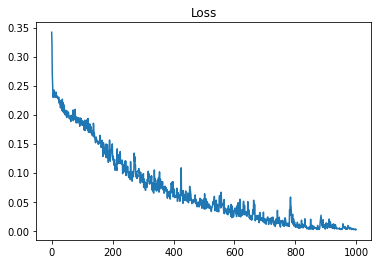

In [221]:
lr = 0.001#0.001
gru_model = train(train_loader, lr, model_type="GRU")

#The target size means the label size!

In [222]:
model=gru_model
i=1
inp = torch.from_numpy(np.array(test_x))
labs = torch.from_numpy(np.array(test_y))
#h = model.init_hidden(inp.shape[0])
h = model.init_hidden(inp.shape[0])
#print("inp",inp)

#print("INP SHAPE",inp.shape)
#print("INP SHAPE[0]",inp.shape[0])
#print("labs",labs)
#print("h",h)
#print("h.shape",h.shape)
#print(inp.to(device).float())
#print(inp.to(device).float().shape)
print(inp.to(device).float().shape)

out, h = model(inp.to(device).float(), h)
#print(out)

torch.Size([24, 5, 11])


In [225]:
gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
#gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
print(test_y)
print(gru_outputs)


Evaluation Time: 0.0018230000000016844
sMAPE: 16.59296018198458%
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]]
[array([ 0.87232876,  0.8646278 ,  0.9905584 ,  0.5201798 ,  0.76008016,
        1.0002005 ,  0.24162246,  0.04132307,  1.0908147 ,  0.64322084,
        0.9649797 ,  1.020373  ,  0.27396506, -0.08782844, -0.20050624,
        0.8749932 ,  0.81944567,  1.1119702 ,  1.1061164 ,  0.31936952,
        0.7629091 ,  0.46462655,  0.40594897,  1.1579341 ], dtype=float32)]


In [247]:
#print(test_y.reshape(-1))

m = nn.ReLU()
#output = m(input)


testy=test_y.reshape(-1)
print(testy.size)
print(gru_outputs[0][4])
for i in range(24):
    print(testy[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))
    #print(testy[i])
    #print
    #output = m(input)


24
0.76008016
1.0 0.87232876 tensor(0.8723)
1.0 0.8646278 tensor(0.8646)
1.0 0.9905584 tensor(0.9906)
1.0 0.5201798 tensor(0.5202)
1.0 0.76008016 tensor(0.7601)
0.0 1.0002005 tensor(1.0002)
1.0 0.24162246 tensor(0.2416)
0.0 0.041323073 tensor(0.0413)
1.0 1.0908147 tensor(1.0908)
0.0 0.64322084 tensor(0.6432)
1.0 0.9649797 tensor(0.9650)
0.0 1.020373 tensor(1.0204)
1.0 0.27396506 tensor(0.2740)
0.0 -0.08782844 tensor(0.)
0.0 -0.20050624 tensor(0.)
0.0 0.8749932 tensor(0.8750)
1.0 0.81944567 tensor(0.8194)
1.0 1.1119702 tensor(1.1120)
1.0 1.1061164 tensor(1.1061)
0.0 0.31936952 tensor(0.3194)
1.0 0.7629091 tensor(0.7629)
1.0 0.46462655 tensor(0.4646)
1.0 0.40594897 tensor(0.4059)
0.0 1.1579341 tensor(1.1579)
